# Third Stage

In [51]:
from get_data import *
from simulation import *
from optimization import *
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import tqdm
import seaborn as sns
import os
import glob
import warnings
warnings.filterwarnings('ignore')

#### Run the command in terminal to trigger optimization jobs that save results to `optres/*`

```
python optimization.py -C 0050 -S bid --ts_start=10 --ts_step=5 --ts_end=120 --tm_start=5 --tm_step=5 --tm_end=120
```
#### `optres` structure
```
optres/stock_code=0050/ts=10/tm=5/yyyy-mm-dd.csv
```

#### Instructions
```
python optimization.py --help
usage: optimization.py [-h] [-C STOCK_CODE] [-S SIDE] [--ts_start TS_START] [--ts_step TS_STEP] [--ts_end TS_END] [--tm_start TM_START] [--tm_step TM_STEP] [--tm_end TM_END]

optional arguments:
  -h, --help            show this help message and exit
  -C STOCK_CODE, --code STOCK_CODE Stock code to simulate
  -S SIDE, --side SIDE  bid or ask
  --ts_start TS_START   T star start
  --ts_step TS_STEP     T star step
  --ts_end TS_END       T star end
  --tm_start TM_START   T mid start
  --tm_step TM_STEP     T mid step
  --tm_end TM_END       T mid end
```

#### Or alternatively run the below cells (log output maybe too long that will crash jupyter notebook/lab)

In [2]:
stock_code = '0050'
side = 'bid'
ts_ls = list(range(10, 120 + 1, 5))
tm_ls = list(range(5, 120 + 1, 5))

# Uncomment to run
# opt_main(stock_code=args.stock_code, side=args.side, ts_ls=ts_ls, tm_ls=tm_ls)

### 1. Collect optimization results

In [3]:
target_stock_code = '0050'
target_side = 'bid'

In [ ]:
file_df = get_path_df(stock_code=target_stock_code, side=target_side)

### 2. Calculate score of each optimization

The objective function is defined below:

In [4]:
obj?

Signature: obj(pnl, t_exec, lmda=1, t_func=<function <lambda> at 0x7f8cc8c02940>)
Docstring:
Objective function for measuring the spread narrowing strategy - score = (lmda / t_func(t_exec)) + pnl

:param pnl: pnl against prevailing mid quote, in bps
:param t_exec: execution time in millisecond
:param lmda: Scaling factor
:param t_func: Transformation function on t_exec
:return:
File:      ~/Projects/mafs6100_order_placement/simulation.py
Type:      function


In [5]:
# Target dictionary to store results, don't update this dictionary for testing different objective function params
res_dict = {}

In [62]:
# Objective function params definition
obj_kwargs = {'lmda': 1, 't_func': lambda x: (x / 1000) + 1}

In [63]:
gb = files_df.groupby(['stock_code', 'side', 'ts', 'tm'])
iter_tqdm = tqdm.tqdm(gb, desc='Calculating', ncols=200, total=len(gb.groups))
for k, df in iter_tqdm:
    iter_tqdm.set_description(f'Calculating[{"|".join(k)}]')
    if k not in res_dict.keys():
        res_dict[k] = get_sim_res(path_ls=df['path'].unique().tolist())
    res_score = obj(res_dict[k]['pnl'], res_dict[k]['duration'], **obj_kwargs)
    res_score = res_score[np.logical_and(~np.isnan(res_score), ~np.isinf(res_score))]
    res_dict[k].update({
        'scores': res_score, 
        'score_mean': np.nanmean(res_score), 
        'score_std': np.nanstd(res_score)
    })

Calculating[0050|bid|95|95]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 819/819 [00:27<00:00, 29.94it/s]


### 3. Compare across different params

In [64]:
target_stock_code = '0050'
target_side = 'bid'
target_res_dict = {k: v for k, v in res_dict.items() if target_stock_code in k and target_side in k}

Text(0.5, 1.0, '0050 - bid - score_mean')

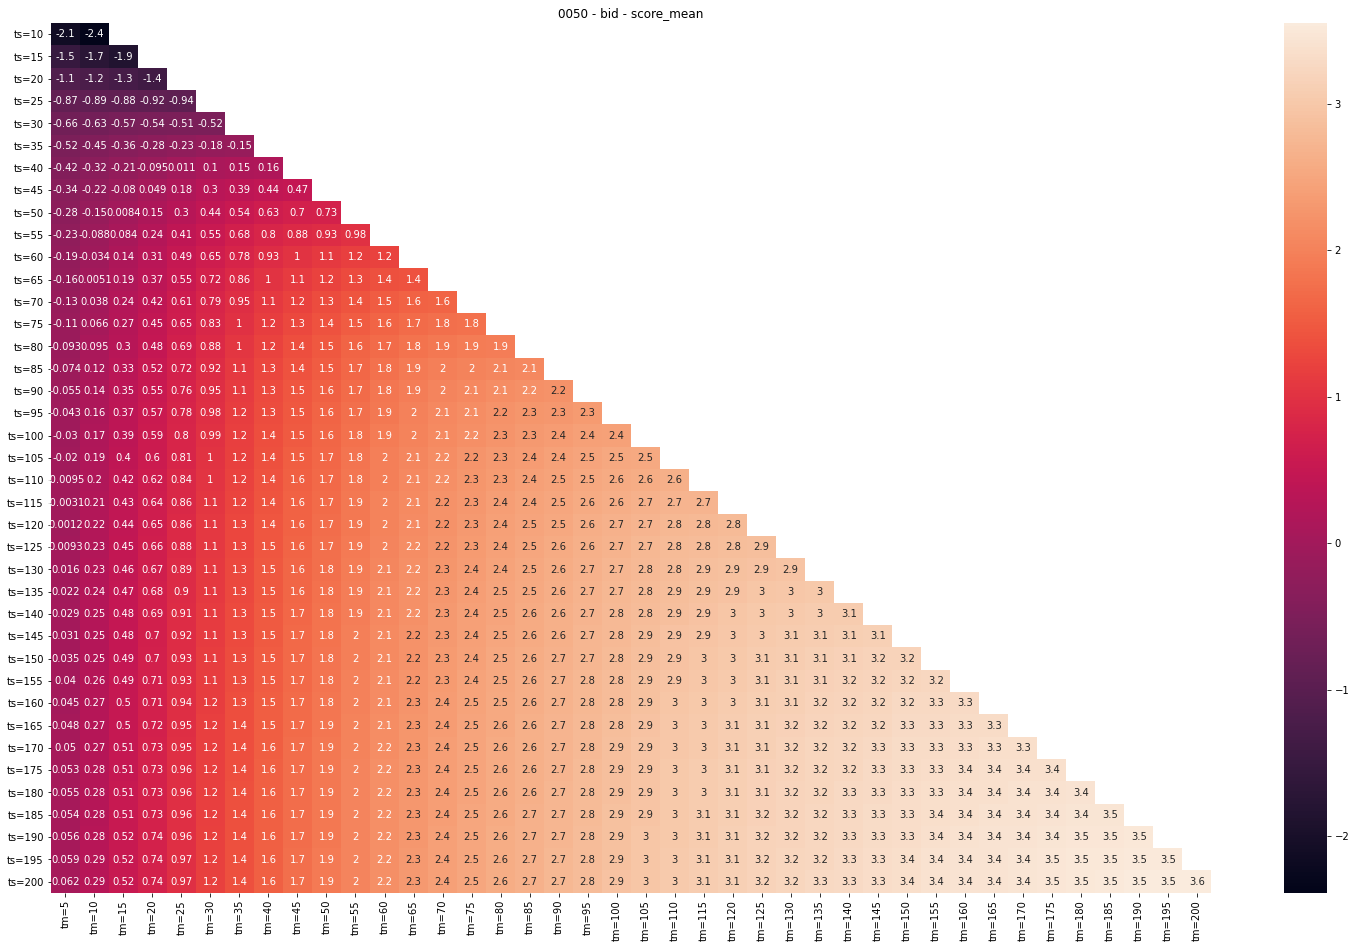

In [65]:
# Plot
plot_attri = 'score_mean'
ts_ls = sorted(list(set([int(i[2]) for i in target_res_dict.keys()])))
tm_ls = sorted(list(set([int(i[3]) for i in target_res_dict.keys()])))
matrix_df = pd.DataFrame(np.nan, index=[f'ts={i}' for i in ts_ls], columns=[f'tm={i}' for i in tm_ls])
for k, v in target_res_dict.items():
    matrix_df.loc[f'ts={k[2]}', f'tm={k[3]}'] = v[plot_attri]
fig, ax = plt.subplots(figsize=(26, 16))
sns.heatmap(matrix_df, ax=ax, annot=True, fmt='.2g')
ax.set_title(f'{target_stock_code} - {target_side} - {plot_attri}')